# NER for constructing KG

In [1]:
!pip install datasets torch pytorch-crf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torchcrf import CRF
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

## EDA and preprocessing CoNLL04


In this experiment will be used [CoNLL04 dataset](https://huggingface.co/datasets/DFKI-SLT/conll04) which contains extracted named entities (ORG, LOC, PER, MISC), their relations (Located_In, Work_For, OrgBased_In, Live_In, Kill), and corresponding texts. The CoNLL04 dataset is a benchmark dataset for relation extraction tasks. The data is primarily based on news articles. The original dataset is governed by the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 International License (CC BY-NC-SA 3.0) and can be found [here](https://cogcomp.seas.upenn.edu/page/resource_view/43)

In [97]:
dataset = load_dataset("DFKI-SLT/conll04")

The dataset has already contained data for training, validation and testing. Let's convert all JSON data in DataFrame.

In [98]:
df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train.head()

entities  \
0  [{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...   
1  [{'end': 26, 'start': 22, 'type': 'Other'}, {'...   
2  [{'end': 21, 'start': 19, 'type': 'Other'}, {'...   
3  [{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...   
4  [{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...   

                                              tokens  \
0  [Newspaper, `, Explains, ', U.S., Interests, S...   
1  [`, `, If, it, does, not, snow, ,, and, a, lot...   
2  [The, self-propelled, rig, Avco, 5, was, heade...   
3  [Annie, Oakley, ,, also, known, as, Little, Mi...   
4  [Penry, raped, Pamela, Moseley, Carpenter, on,...   

                                           relations  orig_id  
0    [{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]     3255  
1       [{'head': 3, 'tail': 4, 'type': 'Work_For'}]       95  
2     [{'head': 2, 'tail': 1, 'type': 'Located_In'}]     2447  
3  [{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...     5284  
4     [{'head': 3, 'tail': 4, 'type': 'Located_In'}]      210

The dataset does not contain NaNs, all columns (instead of unique id) are of object data type.

In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   entities   922 non-null    object
 1   tokens     922 non-null    object
 2   relations  922 non-null    object
 3   orig_id    922 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


Let's provide basic statistics

In [100]:
print("Training samples:", len(df_train))
print("Test samples:", len(df_test))

Training samples: 922
Test samples: 288


#### Texts and tokens

In [101]:
df_train["texts"] = df_train["tokens"].apply(lambda x: " ".join(x))
df_test["texts"] = df_test["tokens"].apply(lambda x: " ".join(x))
df_train.head()

entities  \
0  [{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...   
1  [{'end': 26, 'start': 22, 'type': 'Other'}, {'...   
2  [{'end': 21, 'start': 19, 'type': 'Other'}, {'...   
3  [{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...   
4  [{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...   

                                              tokens  \
0  [Newspaper, `, Explains, ', U.S., Interests, S...   
1  [`, `, If, it, does, not, snow, ,, and, a, lot...   
2  [The, self-propelled, rig, Avco, 5, was, heade...   
3  [Annie, Oakley, ,, also, known, as, Little, Mi...   
4  [Penry, raped, Pamela, Moseley, Carpenter, on,...   

                                           relations  orig_id  \
0    [{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]     3255   
1       [{'head': 3, 'tail': 4, 'type': 'Work_For'}]       95   
2     [{'head': 2, 'tail': 1, 'type': 'Located_In'}]     2447   
3  [{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...     5284   
4     [{'head': 3, 'tail': 4, 'type': 'Located_In'}]      210   

                                               texts  
0  Newspaper ` Explains ' U.S. Interests Section ...  
1  ` ` If it does not snow , and a lot , within t...  
2  The self-propelled rig Avco 5 was headed to sh...  
3  Annie Oakley , also known as Little Miss Sure ...  
4  Penry raped Pamela Moseley Carpenter on Oct. 1...

Examples of texts

In [102]:
for i in df_train.sample(frac=1).head(5)['texts']:
    print(i)

` ` It was torn to shreds , ' ' said Beatrice Martinez , public relations secretary at the Ontario airport , about 40 miles east of Los Angeles .
Today 's Highlight in History : One hundred years ago , on Oct. 14 , 1890 , Dwight D. Eisenhower , the 34th president of the United States , was born in Denison , Texas .
The United States , Britain and France joined in vetoing a Security Council resolution that ` ` deplored ' ' the U.S. Navy 's downing of two Libyan military jets over the Mediterranean on Jan. 4 .
Still , many are encouraged by the election last year of Louisiana 's reform-minded governor , Buddy Roemer , a property tax increase last April , and a new , expanded school board .
The details : _ ` ` Thirty Seconds Over Tokyo ' ' _ An America demoralized by the surprise and destructive Japanese attack on American forces at Pearl Harbor , Hawaii , on Dec. 7 , 1941 , and the subsequent heavy losses to the Japanese in the first months of the war was electrified by news of the first

Plot token count distribution

Total Tokens: 26525
Average Tokens Per Row: 28.77


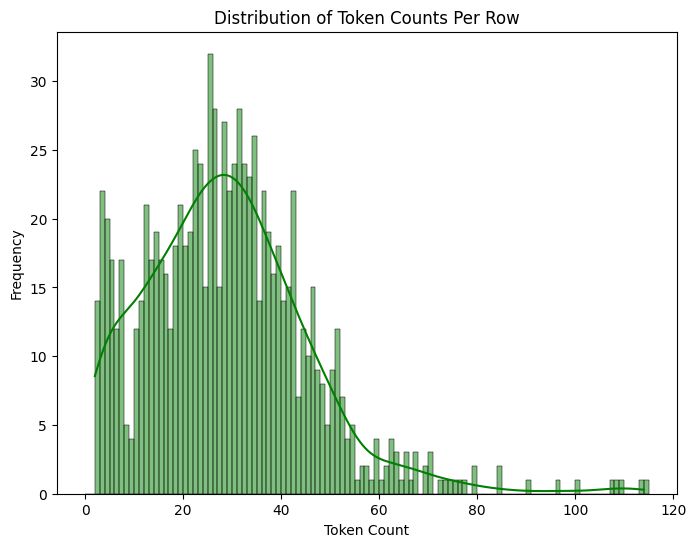

In [103]:
token_counts = [len(tokens) for tokens in df_train['tokens']]
total_tokens = sum(token_counts)
average_token_length = sum(token_counts) / len(token_counts)

print(f"Total Tokens: {total_tokens}")
print(f"Average Tokens Per Row: {average_token_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=range(0, max(token_counts) + 2), kde=True, color='green')
plt.title('Distribution of Token Counts Per Row')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Total Characters: 143962
Average Characters Per Row: 156.14


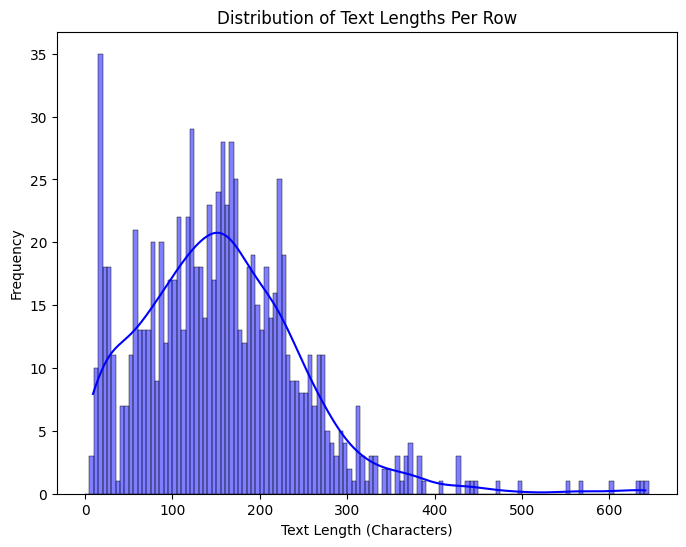

In [104]:
text_lengths = [len(text) for text in df_train['texts']]
total_text_length = sum(text_lengths)
average_text_length = sum(text_lengths) / len(text_lengths)

print(f"Total Characters: {total_text_length}")
print(f"Average Characters Per Row: {average_text_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=range(0, max(text_lengths) + 5, 5), kde=True, color='blue')
plt.title('Distribution of Text Lengths Per Row')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

#### Entities

In [105]:
def create_named_entities(entities, tokens):
    named_entities = []
    for entity in entities:
        start = entity['start']
        end = entity['end']
        entity_type = entity['type']
        entity_text = ' '.join(tokens[start:end])
        entry = f"{entity_text} ({start}, {end}) : {entity_type}"
        named_entities.append(entry)
    return named_entities

In [106]:
df_train['named_entities'] = df_train.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_train

entities  \
0    [{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...   
1    [{'end': 26, 'start': 22, 'type': 'Other'}, {'...   
2    [{'end': 21, 'start': 19, 'type': 'Other'}, {'...   
3    [{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...   
4    [{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...   
..                                                 ...   
917  [{'end': 1, 'start': 0, 'type': 'Other'}, {'en...   
918  [{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...   
919  [{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...   
920  [{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...   
921  [{'end': 5, 'start': 4, 'type': 'Org'}, {'end'...   

                                                tokens  \
0    [Newspaper, `, Explains, ', U.S., Interests, S...   
1    [`, `, If, it, does, not, snow, ,, and, a, lot...   
2    [The, self-propelled, rig, Avco, 5, was, heade...   
3    [Annie, Oakley, ,, also, known, as, Little, Mi...   
4    [Penry, raped, Pamela, Moseley, Carpenter, on,...   
..                                                 ...   
917  [An-a-one, ,, an-a-two, ,, an-a-three, billion...   
918  [Another, GE, employee, ,, attorney, Robert, C...   
919  [(, Text, ), Following, the, conclusion, of, t...   
920  [Eaglebrook, East, opened, in, Middletown, in,...   
921  [Scattered, among, reams, of, FBI, and, Secret...   

                                             relations  orig_id  \
0      [{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]     3255   
1         [{'head': 3, 'tail': 4, 'type': 'Work_For'}]       95   
2       [{'head': 2, 'tail': 1, 'type': 'Located_In'}]     2447   
3    [{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...     5284   
4       [{'head': 3, 'tail': 4, 'type': 'Located_In'}]      210   
..                                                 ...      ...   
917        [{'head': 1, 'tail': 2, 'type': 'Live_In'}]     5423   
918       [{'head': 1, 'tail': 0, 'type': 'Work_For'}]     1269   
919  [{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...     4136   
920    [{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]     1452   
921           [{'head': 2, 'tail': 4, 'type': 'Kill'}]     5058   

                                                 texts  \
0    Newspaper ` Explains ' U.S. Interests Section ...   
1    ` ` If it does not snow , and a lot , within t...   
2    The self-propelled rig Avco 5 was headed to sh...   
3    Annie Oakley , also known as Little Miss Sure ...   
4    Penry raped Pamela Moseley Carpenter on Oct. 1...   
..                                                 ...   
917  An-a-one , an-a-two , an-a-three billion ) Tax...   
918  Another GE employee , attorney Robert C. Ander...   
919  ( Text ) Following the conclusion of the Genev...   
920    Eaglebrook East opened in Middletown in April .   
921  Scattered among reams of FBI and Secret Servic...   

                                        named_entities  
0    [U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...  
1    [150 , 000 hectares (22, 26) : Other, 370 , 50...  
2    [20 miles (19, 21) : Other, Louisiana (23, 24)...  
3    [Annie Oakley (0, 2) : Peop, Little Miss Sure ...  
4    [Penry (0, 1) : Peop, Pamela Moseley Carpenter...  
..                                                 ...  
917  [An-a-one (0, 1) : Other, Lawrence Welk (18, 2...  
918  [GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...  
919  [Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...  
920  [Eaglebrook East (0, 2) : Org, Middletown (4, ...  
921  [FBI (4, 5) : Org, Secret Service (6, 8) : Org...  

[922 rows x 6 columns]

In [107]:
def categorize_entities(entities_list):
    categories = {'Peop': 0, 'Loc': 0, 'Org': 0, 'Other': 0}
    for entity_str in entities_list:
        parts = entity_str.split(': ')
        if len(parts) >= 2:
            entity_type = parts[1].strip()
            if entity_type in categories:
                categories[entity_type] += 1
    return categories

In [108]:
train_ent = df_train[['orig_id', 'named_entities']]
train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)
train_ent

<ipython-input-108-1b412a188198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)


orig_id                                     named_entities  \
0       3255  [U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...   
1         95  [150 , 000 hectares (22, 26) : Other, 370 , 50...   
2       2447  [20 miles (19, 21) : Other, Louisiana (23, 24)...   
3       5284  [Annie Oakley (0, 2) : Peop, Little Miss Sure ...   
4        210  [Penry (0, 1) : Peop, Pamela Moseley Carpenter...   
..       ...                                                ...   
917     5423  [An-a-one (0, 1) : Other, Lawrence Welk (18, 2...   
918     1269  [GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...   
919     4136  [Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...   
920     1452  [Eaglebrook East (0, 2) : Org, Middletown (4, ...   
921     5058  [FBI (4, 5) : Org, Secret Service (6, 8) : Org...   

                               entity_categories  
0    {'Peop': 0, 'Loc': 2, 'Org': 1, 'Other': 2}  
1    {'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 3}  
2    {'Peop': 1, 'Loc': 2, 'Org': 0, 'Other': 1}  
3    {'Peop': 3, 'Loc': 1, 'Org': 0, 'Other': 0}  
4    {'Peop': 2, 'Loc': 2, 'Org': 0, 'Other': 1}  
..                                           ...  
917  {'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 1}  
918  {'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 0}  
919  {'Peop': 1, 'Loc': 2, 'Org': 1, 'Other': 0}  
920  {'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 0}  
921  {'Peop': 2, 'Loc': 0, 'Org': 3, 'Other': 0}  

[922 rows x 3 columns]

In [109]:
categories = ['Peop', 'Loc', 'Org', 'Other']

encoded_ent = train_ent['entity_categories'].apply(
    lambda x: {cat: x.get(cat, 0) for cat in categories}
).apply(pd.Series)

encoded_ent = pd.concat(
    [train_ent[['orig_id']], encoded_ent],
    axis=1
)

encoded_ent

orig_id  Peop  Loc  Org  Other
0       3255     0    2    1      2
1         95     1    0    1      3
2       2447     1    2    0      1
3       5284     3    1    0      0
4        210     2    2    0      1
..       ...   ...  ...  ...    ...
917     5423     1    1    1      1
918     1269     1    0    1      0
919     4136     1    2    1      0
920     1452     0    1    1      0
921     5058     2    0    3      0

[922 rows x 5 columns]

Plot a bar chart

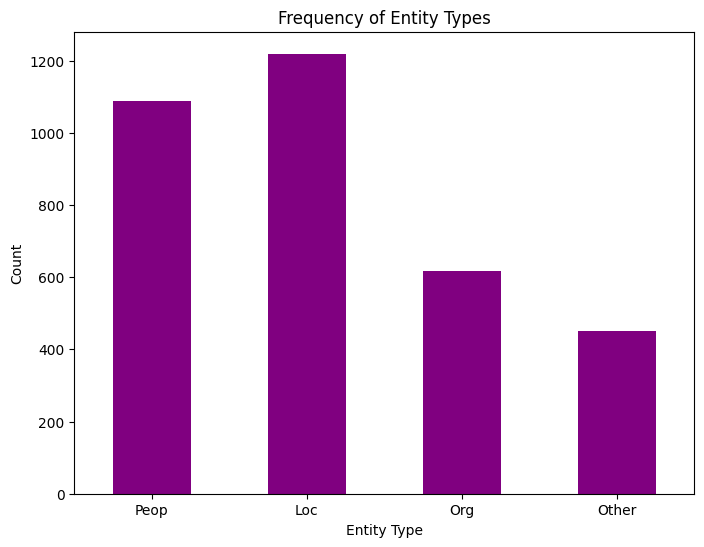

In [110]:
entity_counts = encoded_ent[['Peop', 'Loc', 'Org', 'Other']].sum()

plt.figure(figsize=(8, 6))
entity_counts.plot(kind='bar', color=['purple'])
plt.title('Frequency of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Relations

Let's analyze unique relations

In [111]:
def create_triplets(relations, named_entities):
    triplets = []
    for relation in relations:
        head_idx = relation['head']
        tail_idx = relation['tail']
        rel_type = relation['type']

        head_entity_str = named_entities[head_idx]
        tail_entity_str = named_entities[tail_idx]


        head_entity_type = head_entity_str.split(':')[-1].strip()
        tail_entity_type = tail_entity_str.split(':')[-1].strip()

        # create the triplet using only the types of entities
        triplet = f"{head_entity_type}|{rel_type}|{tail_entity_type}"
        triplets.append(triplet)
    return triplets


In [112]:
df_train['triplets'] = df_train.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_train

entities  \
0    [{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...   
1    [{'end': 26, 'start': 22, 'type': 'Other'}, {'...   
2    [{'end': 21, 'start': 19, 'type': 'Other'}, {'...   
3    [{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...   
4    [{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...   
..                                                 ...   
917  [{'end': 1, 'start': 0, 'type': 'Other'}, {'en...   
918  [{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...   
919  [{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...   
920  [{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...   
921  [{'end': 5, 'start': 4, 'type': 'Org'}, {'end'...   

                                                tokens  \
0    [Newspaper, `, Explains, ', U.S., Interests, S...   
1    [`, `, If, it, does, not, snow, ,, and, a, lot...   
2    [The, self-propelled, rig, Avco, 5, was, heade...   
3    [Annie, Oakley, ,, also, known, as, Little, Mi...   
4    [Penry, raped, Pamela, Moseley, Carpenter, on,...   
..                                                 ...   
917  [An-a-one, ,, an-a-two, ,, an-a-three, billion...   
918  [Another, GE, employee, ,, attorney, Robert, C...   
919  [(, Text, ), Following, the, conclusion, of, t...   
920  [Eaglebrook, East, opened, in, Middletown, in,...   
921  [Scattered, among, reams, of, FBI, and, Secret...   

                                             relations  orig_id  \
0      [{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]     3255   
1         [{'head': 3, 'tail': 4, 'type': 'Work_For'}]       95   
2       [{'head': 2, 'tail': 1, 'type': 'Located_In'}]     2447   
3    [{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...     5284   
4       [{'head': 3, 'tail': 4, 'type': 'Located_In'}]      210   
..                                                 ...      ...   
917        [{'head': 1, 'tail': 2, 'type': 'Live_In'}]     5423   
918       [{'head': 1, 'tail': 0, 'type': 'Work_For'}]     1269   
919  [{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...     4136   
920    [{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]     1452   
921           [{'head': 2, 'tail': 4, 'type': 'Kill'}]     5058   

                                                 texts  \
0    Newspaper ` Explains ' U.S. Interests Section ...   
1    ` ` If it does not snow , and a lot , within t...   
2    The self-propelled rig Avco 5 was headed to sh...   
3    Annie Oakley , also known as Little Miss Sure ...   
4    Penry raped Pamela Moseley Carpenter on Oct. 1...   
..                                                 ...   
917  An-a-one , an-a-two , an-a-three billion ) Tax...   
918  Another GE employee , attorney Robert C. Ander...   
919  ( Text ) Following the conclusion of the Genev...   
920    Eaglebrook East opened in Middletown in April .   
921  Scattered among reams of FBI and Secret Servic...   

                                        named_entities  \
0    [U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...   
1    [150 , 000 hectares (22, 26) : Other, 370 , 50...   
2    [20 miles (19, 21) : Other, Louisiana (23, 24)...   
3    [Annie Oakley (0, 2) : Peop, Little Miss Sure ...   
4    [Penry (0, 1) : Peop, Pamela Moseley Carpenter...   
..                                                 ...   
917  [An-a-one (0, 1) : Other, Lawrence Welk (18, 2...   
918  [GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...   
919  [Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...   
920  [Eaglebrook East (0, 2) : Org, Middletown (4, ...   
921  [FBI (4, 5) : Org, Secret Service (6, 8) : Org...   

                                              triplets  
0                                [Org|OrgBased_In|Loc]  
1                                  [Peop|Work_For|Org]  
2                                 [Loc|Located_In|Loc]  
3    [Peop|Live_In|Loc, Peop|Live_In|Loc, Peop|Live...  
4                                 [Loc|Located_In|Loc]  
..                                                 ...  
917                                 [Peop|Live_In|Loc]

In [113]:
unique_triplets = set()

for triplet_list in df_train['triplets']:
    if isinstance(triplet_list, list):
        for triplet in triplet_list:
            unique_triplets.add(triplet)

unique_triplets_list = list(unique_triplets)
unique_triplets_list

['Org|OrgBased_In|Loc',
 'Peop|Kill|Peop',
 'Peop|Live_In|Loc',
 'Loc|Located_In|Loc',
 'Peop|Work_For|Org']

#### Triplets

So let's visualize a distribution of triplets each row

In [114]:
df_train['triplet_count'] = df_train['triplets'].apply(len)
df_train

entities  \
0    [{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...   
1    [{'end': 26, 'start': 22, 'type': 'Other'}, {'...   
2    [{'end': 21, 'start': 19, 'type': 'Other'}, {'...   
3    [{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...   
4    [{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...   
..                                                 ...   
917  [{'end': 1, 'start': 0, 'type': 'Other'}, {'en...   
918  [{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...   
919  [{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...   
920  [{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...   
921  [{'end': 5, 'start': 4, 'type': 'Org'}, {'end'...   

                                                tokens  \
0    [Newspaper, `, Explains, ', U.S., Interests, S...   
1    [`, `, If, it, does, not, snow, ,, and, a, lot...   
2    [The, self-propelled, rig, Avco, 5, was, heade...   
3    [Annie, Oakley, ,, also, known, as, Little, Mi...   
4    [Penry, raped, Pamela, Moseley, Carpenter, on,...   
..                                                 ...   
917  [An-a-one, ,, an-a-two, ,, an-a-three, billion...   
918  [Another, GE, employee, ,, attorney, Robert, C...   
919  [(, Text, ), Following, the, conclusion, of, t...   
920  [Eaglebrook, East, opened, in, Middletown, in,...   
921  [Scattered, among, reams, of, FBI, and, Secret...   

                                             relations  orig_id  \
0      [{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]     3255   
1         [{'head': 3, 'tail': 4, 'type': 'Work_For'}]       95   
2       [{'head': 2, 'tail': 1, 'type': 'Located_In'}]     2447   
3    [{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...     5284   
4       [{'head': 3, 'tail': 4, 'type': 'Located_In'}]      210   
..                                                 ...      ...   
917        [{'head': 1, 'tail': 2, 'type': 'Live_In'}]     5423   
918       [{'head': 1, 'tail': 0, 'type': 'Work_For'}]     1269   
919  [{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...     4136   
920    [{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]     1452   
921           [{'head': 2, 'tail': 4, 'type': 'Kill'}]     5058   

                                                 texts  \
0    Newspaper ` Explains ' U.S. Interests Section ...   
1    ` ` If it does not snow , and a lot , within t...   
2    The self-propelled rig Avco 5 was headed to sh...   
3    Annie Oakley , also known as Little Miss Sure ...   
4    Penry raped Pamela Moseley Carpenter on Oct. 1...   
..                                                 ...   
917  An-a-one , an-a-two , an-a-three billion ) Tax...   
918  Another GE employee , attorney Robert C. Ander...   
919  ( Text ) Following the conclusion of the Genev...   
920    Eaglebrook East opened in Middletown in April .   
921  Scattered among reams of FBI and Secret Servic...   

                                        named_entities  \
0    [U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...   
1    [150 , 000 hectares (22, 26) : Other, 370 , 50...   
2    [20 miles (19, 21) : Other, Louisiana (23, 24)...   
3    [Annie Oakley (0, 2) : Peop, Little Miss Sure ...   
4    [Penry (0, 1) : Peop, Pamela Moseley Carpenter...   
..                                                 ...   
917  [An-a-one (0, 1) : Other, Lawrence Welk (18, 2...   
918  [GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...   
919  [Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...   
920  [Eaglebrook East (0, 2) : Org, Middletown (4, ...   
921  [FBI (4, 5) : Org, Secret Service (6, 8) : Org...   

                                              triplets  triplet_count  
0                                [Org|OrgBased_In|Loc]              1  
1                                  [Peop|Work_For|Org]              1  
2                                 [Loc|Located_In|Loc]              1  
3    [Peop|Live_In|Loc, Peop|Live_In|Loc, Peop|Live...              3  
4                                 [Loc|Located_In|Loc]              1  
..                   

In [115]:
#triplet_count for test
df_test['named_entities'] = df_test.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_test['triplets'] = df_test.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_test['triplet_count'] = df_test['triplets'].apply(len)
df_test

entities  \
0    [{'end': 7, 'start': 5, 'type': 'Org'}, {'end'...   
1    [{'end': 1, 'start': 0, 'type': 'Loc'}, {'end'...   
2    [{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...   
3    [{'end': 16, 'start': 15, 'type': 'Org'}, {'en...   
4    [{'end': 16, 'start': 13, 'type': 'Org'}, {'en...   
..                                                 ...   
283  [{'end': 1, 'start': 0, 'type': 'Other'}, {'en...   
284  [{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...   
285  [{'end': 2, 'start': 1, 'type': 'Other'}, {'en...   
286  [{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...   
287  [{'end': 2, 'start': 1, 'type': 'Loc'}, {'end'...   

                                                tokens  \
0    [An, art, exhibit, at, the, Hakawati, Theatre,...   
1                        [PERUGIA, ,, Italy, (, AP, )]   
2    [Reagan, sounded, positive, notes, reminiscent...   
3    [There, was, no, mention, of, the, `, `, iron,...   
4    [Nor, did, he, argue, ,, as, he, did, in, a, s...   
..                                                 ...   
283  [Photo, ,, COLOR, ,, The, father, of, our, 34t...   
284  [Bette, Davis, was, born, Ruth, Elizabeth, Dav...   
285  [On, Oct., 18, ,, 1921, ,, Jesse, Alexander, H...   
286  [The, House, voted, Thursday, to, withdraw, a,...   
287  [In, Indiana, ,, downed, tree, limbs, interrup...   

                                             relations  orig_id  \
0      [{'head': 0, 'tail': 2, 'type': 'OrgBased_In'}]       17   
1    [{'head': 0, 'tail': 1, 'type': 'Located_In'},...       23   
2          [{'head': 0, 'tail': 2, 'type': 'Live_In'}]       34   
3      [{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]       35   
4      [{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]       36   
..                                                 ...      ...   
283        [{'head': 2, 'tail': 4, 'type': 'Live_In'}]     5402   
284  [{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...     5408   
285        [{'head': 1, 'tail': 2, 'type': 'Live_In'}]     5410   
286        [{'head': 2, 'tail': 3, 'type': 'Live_In'}]     5413   
287     [{'head': 1, 'tail': 0, 'type': 'Located_In'}]     5905   

                                                 texts  \
0    An art exhibit at the Hakawati Theatre in Arab...   
1                               PERUGIA , Italy ( AP )   
2    Reagan sounded positive notes reminiscent of e...   
3    There was no mention of the ` ` iron triangle ...   
4    Nor did he argue , as he did in a speech at th...   
..                                                 ...   
283  Photo , COLOR , The father of our 34th Preside...   
284  Bette Davis was born Ruth Elizabeth Davis on A...   
285  On Oct. 18 , 1921 , Jesse Alexander Helms Jr. ...   
286  The House voted Thursday to withdraw a grant t...   
287  In Indiana , downed tree limbs interrupted pow...   

                                        named_entities  \
0    [Hakawati Theatre (5, 7) : Org, Arab (8, 9) : ...   
1    [PERUGIA (0, 1) : Loc, Italy (2, 3) : Loc, AP ...   
2    [Reagan (0, 1) : Peop, American (26, 27) : Oth...   
3    [Congress (15, 16) : Org, Washington (33, 34) ...   
4    [University of Virginia (13, 16) : Org, Charlo...   
..                                                 ...   
283  [Photo (0, 1) : Other, COLOR (2, 3) : Other, D...   
284  [Bette Davis (0, 2) : Peop, Ruth Elizabeth Dav...   
285  [Oct. (1, 2) : Other, Jesse Alexander Helms Jr...   
286  [House (1, 2) : Org, Thursday (3, 4) : Other, ...   
287  [Indiana (1, 2) : Loc, Indianapolis (11, 12) :...   

                                              triplets  triplet_count  
0                                [Org|OrgBased_In|Loc]              1  
1    [Loc|Located_In|Loc, Org|OrgBased_In|Loc, Org|...              3  
2                                   [Peop|Live_In|Loc]              1  
3                                [Org|OrgBased_In|Loc]              1  
4                                [Org|OrgBased_In|Loc]              1  
..                   

In [116]:
df_croped_test = df_test[
    (df_test['triplet_count'] == 1)
]

Plot the distribution of triplets

Total number of triplets in the dataset: 1283


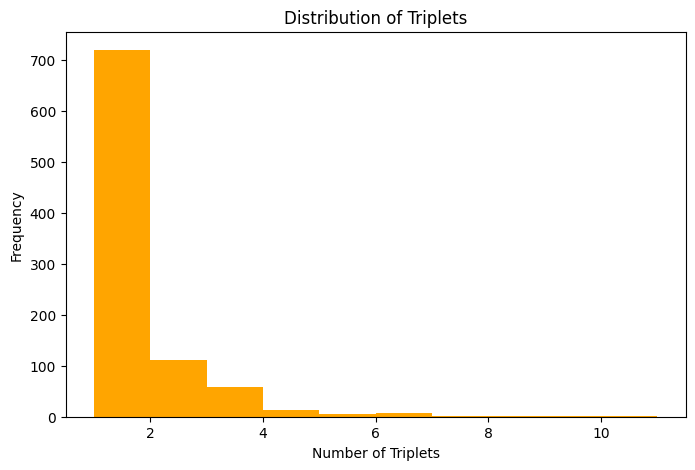

In [117]:
total_triplets = df_train['triplet_count'].sum()
print(f"Total number of triplets in the dataset: {total_triplets}")

plt.figure(figsize=(8, 5))
plt.hist(df_train['triplet_count'], bins=range(1, 12), color='orange')
plt.title("Distribution of Triplets")
plt.xlabel("Number of Triplets")
plt.ylabel("Frequency")
plt.show()

## LLM approach for NER task: BERT

The proposed model leverages the BERT as a contextual feature extractor (contextual embeddings state features) and combines it with a Conditional Random Fields (CRF) layer for performing NER task. Transition features represents as IOB2-tagged tokens (BIO-tagging).

The arhitecture of the model was given from [here. [Harnoune A. 2021]](https://www.sciencedirect.com/science/article/pii/S2666990021000410?ref=pdf_download&fr=RR-2&rr=936f9a883908ec56#page=5.30)

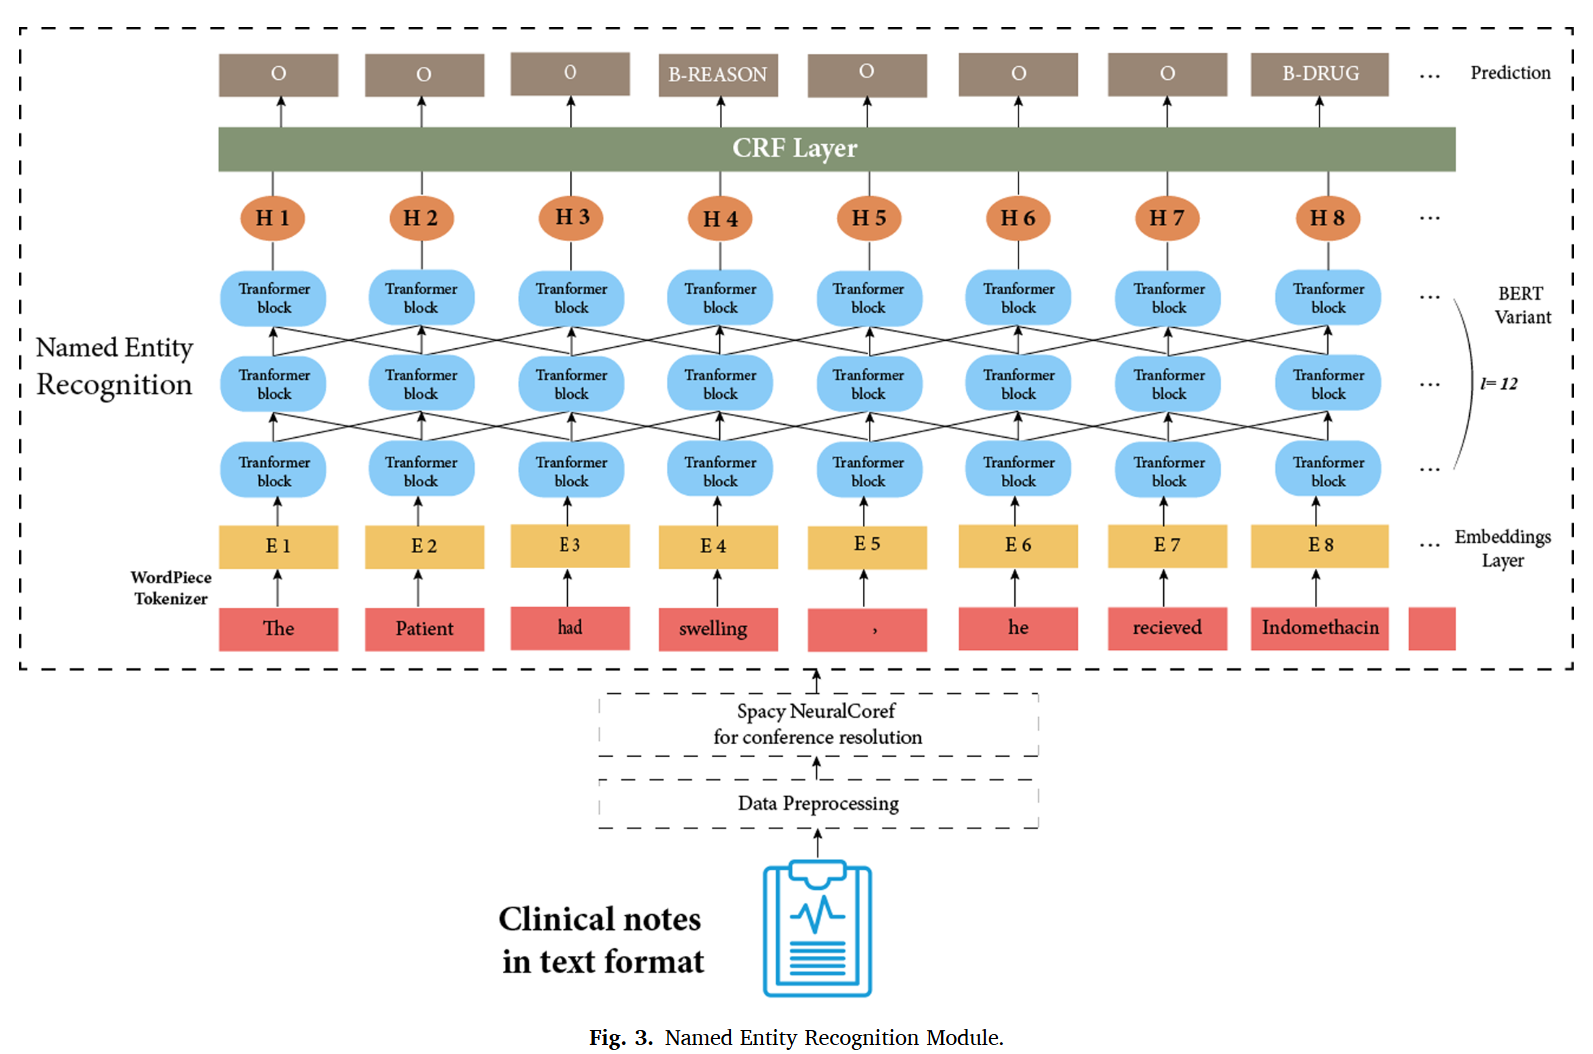


The configuration of the architecture:
* 12 stacked encoders (each layer contains Self-Attention и Feed-Forward Network)
* hidden size = 768 (the number of features of the
hidden state -- standart)
* 12 heads in the MultiHead attention layers
* input size = 128 (max len of seq per step was reduced for optimization)
* batch size = 17 (num of examples per step was reduced for optimization
* num of epochs = 10
- a **CRF layer** which allows to link the result obtained with the
appropriate class of the named entity

### Preprocessing data

Let's make biotagging for all samples.

In [24]:
def generate_bio_tags(tokens, entities):
    bio_tags = ['O'] * len(tokens)
    for entity in entities:
        start = entity['start']
        end = entity['end']
        typ = entity['type']
        if start < len(bio_tags):
            bio_tags[start] = f'B-{typ}'
        for i in range(start + 1, end):
            if i < len(bio_tags):
                bio_tags[i] = f'I-{typ}'
    return bio_tags

In [25]:
df_train['bio_tags'] = df_train.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_val['bio_tags'] = df_val.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_test['bio_tags'] = df_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)

df_train = df_train[['tokens', 'bio_tags']]
df_val = df_val[['tokens', 'bio_tags']]

df_test = df_test[['tokens', 'bio_tags']]

df_test

tokens  \
0    [An, art, exhibit, at, the, Hakawati, Theatre,...   
1                        [PERUGIA, ,, Italy, (, AP, )]   
2    [Reagan, sounded, positive, notes, reminiscent...   
3    [There, was, no, mention, of, the, `, `, iron,...   
4    [Nor, did, he, argue, ,, as, he, did, in, a, s...   
..                                                 ...   
283  [Photo, ,, COLOR, ,, The, father, of, our, 34t...   
284  [Bette, Davis, was, born, Ruth, Elizabeth, Dav...   
285  [On, Oct., 18, ,, 1921, ,, Jesse, Alexander, H...   
286  [The, House, voted, Thursday, to, withdraw, a,...   
287  [In, Indiana, ,, downed, tree, limbs, interrup...   

                                              bio_tags  
0    [O, O, O, O, O, B-Org, I-Org, O, B-Other, O, B...  
1                       [B-Loc, O, B-Loc, O, B-Org, O]  
2    [B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O...  
3    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
4    [O, O, O, O, O, O, O, O, O, O, O, O, O, B-Org,...  
..                                                 ...  
283  [B-Other, O, B-Other, O, O, O, O, O, O, O, O, ...  
284  [B-Peop, I-Peop, O, O, B-Peop, I-Peop, I-Peop,...  
285  [O, B-Other, O, O, O, O, B-Peop, I-Peop, I-Peo...  
286  [O, B-Org, O, B-Other, O, O, O, O, O, O, O, B-...  
287    [O, B-Loc, O, O, O, O, O, O, O, O, O, B-Loc, O]  

[288 rows x 2 columns]

In [26]:
# numpy array to list
df_train['tokens'] = df_train['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df_val['tokens'] = df_val['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df_test['tokens'] = df_test['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

<ipython-input-26-d6734fa8f856>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tokens'] = df_train['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
<ipython-input-26-d6734fa8f856>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['tokens'] = df_val['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
<ipython-input-26-d6734fa8f856>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

BERT has its own tokenization, which splits words into subtokens. Therefore, we should convert our bio_tags to the BERT format and create NERDataset for training with PyTorch.

In [27]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

label2id = {"O": 0, "B-Peop": 1, "I-Peop": 2, "B-Org": 3, "I-Org": 4, "B-Loc": 5, "I-Loc": 6, "B-Other": 7, "I-Other": 8}
id2label = {v: k for k, v in label2id.items()}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
def tokenize_and_align_labels(tokens, labels, tokenizer, label2id, max_length=128):
    tokenized_inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    word_ids = tokenized_inputs.word_ids()  # list of ID of tokens for each subtoken
    previous_word_idx = None
    aligned_labels = []
    for word_id in word_ids:
        if word_id is None:  # CLS, SEP, or PAD
            aligned_labels.append(0)  # mask will ignore it
        else:
            original_label = labels[word_id]
            if word_id != previous_word_idx:
                aligned_labels.append(label2id[original_label])
                previous_word_idx = word_id
            else:
                if original_label.startswith("B-") or original_label.startswith("I-"):
                    entity_type = original_label[2:]
                    i_label = f"I-{entity_type}"
                    aligned_labels.append(label2id[i_label])
                else:
                    aligned_labels.append(label2id["O"])
    tokenized_inputs["labels"] = torch.tensor(aligned_labels)
    return tokenized_inputs

In [29]:
class NERDataset(Dataset):
    def __init__(self, df, tokenizer, label2id, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens = self.df.iloc[idx]["tokens"]
        labels = self.df.iloc[idx]["bio_tags"]
        tokenized_data = tokenize_and_align_labels(
            tokens,
            labels,
            self.tokenizer,
            self.label2id,
            self.max_length
        )
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(0),
            "attention_mask": tokenized_data["attention_mask"].squeeze(0),
            "labels": tokenized_data["labels"]
        }

In [30]:
train_dataset = NERDataset(df_train, tokenizer, label2id)
train_loader = DataLoader(train_dataset, batch_size=17, shuffle=True)

for i in train_dataset:
  print(f'''input_ids: {i["input_ids"].squeeze(0)}
        \n attention_mask: {i["attention_mask"].squeeze(0)}
        \n labels: {i["labels"]}''')
  break

input_ids: tensor([  101,  3780,  1036,  7607,  1005,  1057,  1012,  1055,  1012,  5426,
         2930,  2824, 13109, 16932,  2692, 28332, 15136,  2683,  2549, 15278,
         2557,  2128,  4135,  3501,  2897,  1999,  3009, 12875,  2692, 13938,
         2102,  2410, 13114,  6365,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

### Training

Let's implement our architecture: BERT (contextual embeddings) + CRF layer

In [31]:
class BertCrf(nn.Module):
    def __init__(self, num_labels, bert_name, dropout=0.4):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        emissions = self.fc(self.dropout(sequence_output))

        if labels is not None:
            log_likelihood = self.crf(emissions, labels, mask=attention_mask.bool())
            return -log_likelihood
        else:
            mask = attention_mask.bool()
            return self.crf.decode(emissions, mask=mask)

    def save_to(self, path):
        torch.save(self.state_dict(), path, _use_new_zipfile_serialization=True)

    def load_from(self, path):
        self.load_state_dict(torch.load(path, map_location='cpu', weights_only=False))

In [32]:
def compute_f1(preds, labels):
    preds_flat = [tag for seq in preds for tag in seq]
    labels_flat = [
        label for seq in labels for label in seq if label != -100  # Ignore -100
    ]

    return f1_score(labels_flat, preds_flat, average='micro')

In [33]:
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Calculate loss
            loss = model(input_ids, attention_mask, labels)
            total_loss += loss.item()

            # Get predictions
            predictions = model(input_ids, attention_mask)

            all_preds.extend(predictions)

            # Flatten labels while ignoring -100
            active_labels = [
                [label for label, mask in zip(seq_labels, seq_mask) if mask]
                for seq_labels, seq_mask in zip(labels.cpu().numpy(), attention_mask.cpu().numpy())
            ]
            all_labels.extend(active_labels)

    avg_val_loss = total_loss / len(val_loader)
    return avg_val_loss, all_preds, all_labels

In [34]:
def visualize_metrics(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, val_losses, label="Val Loss", color="orange")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

Let's train our model using early stopping to improve performance and avoid overfitting.

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertCrf(num_labels=len(label2id), bert_name="bert-base-uncased").to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


def train_model(model, train_loader, val_loader, epochs=10, patience=3):
    model.train()

    train_losses, val_losses, val_f1_scores = [], [], []

    # Early stopping
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            loss = model(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #  Validation
        val_loss, val_preds, val_labels = evaluate_model(model, val_loader)
        val_f1 = compute_f1(val_preds, val_labels)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val micro-F1: {val_f1:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            model.save_to('model.pt')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        # updating learning rate
        scheduler.step()

    visualize_metrics(train_losses, val_losses, val_f1_scores)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 423.1480, Val Loss: 160.0198, Val micro-F1: 0.9223


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 102.4300, Val Loss: 110.8094, Val micro-F1: 0.9451


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 43.7523, Val Loss: 97.9119, Val micro-F1: 0.9524


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 19.4960, Val Loss: 107.6142, Val micro-F1: 0.9513


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 10.2296, Val Loss: 126.6541, Val micro-F1: 0.9520


Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 5.4536, Val Loss: 120.3864, Val micro-F1: 0.9559
Early stopping triggered.


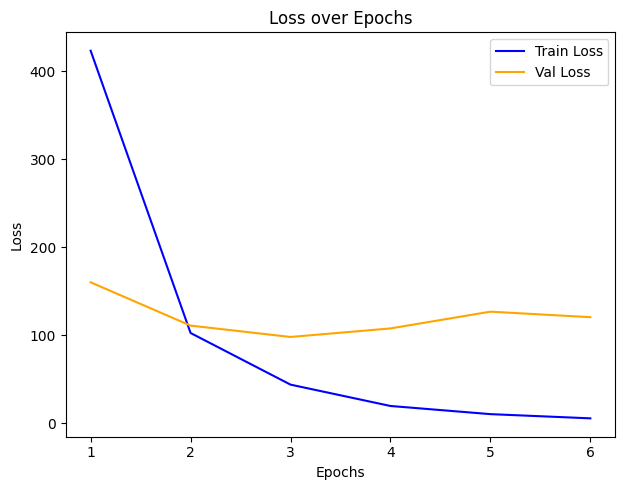

In [36]:
val_dataset = NERDataset(df_val, tokenizer, label2id)
val_loader = DataLoader(val_dataset, batch_size=17, shuffle=False)

train_model(model, train_loader, val_loader, epochs=10, patience=3)

### Evaluating

In [37]:
test_dataset = NERDataset(df_test, tokenizer, label2id)
test_loader = DataLoader(test_dataset, batch_size=17, shuffle=False)

In [38]:
test_loss, test_preds, test_labels = evaluate_model(model, test_loader)

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

In [39]:
true_labels = []
pred_labels = []
for labels_seq, preds_seq in zip(test_labels, test_preds):
    for true_tag, pred_tag in zip(labels_seq, preds_seq):
        if true_tag != -100:
            true_labels.append(id2label[true_tag])
            pred_labels.append(id2label[pred_tag])

print(classification_report(
    true_labels,
    pred_labels,
    digits=4,
    target_names=label2id.keys()
))

              precision    recall  f1-score   support

           O     0.9369    0.9391    0.9380       427
      B-Peop     0.7982    0.8990    0.8456       198
      I-Peop     0.7586    0.6617    0.7068       133
       B-Org     0.9367    0.9688    0.9525       321
       I-Org     0.9002    0.8305    0.8640       478
       B-Loc     0.7992    0.8915    0.8428       424
       I-Loc     0.7650    0.7071    0.7349       198
     B-Other     0.9715    0.9636    0.9675       742
     I-Other     0.9772    0.9758    0.9765      7516

    accuracy                         0.9526     10437
   macro avg     0.8715    0.8708    0.8699     10437
weighted avg     0.9529    0.9526    0.9525     10437



In [40]:
micro_f1 = f1_score(true_labels, pred_labels, average='micro')

print(f"micro-F1: {micro_f1:.4f}")

micro-F1: 0.9526


Let's plot a confusion matrix

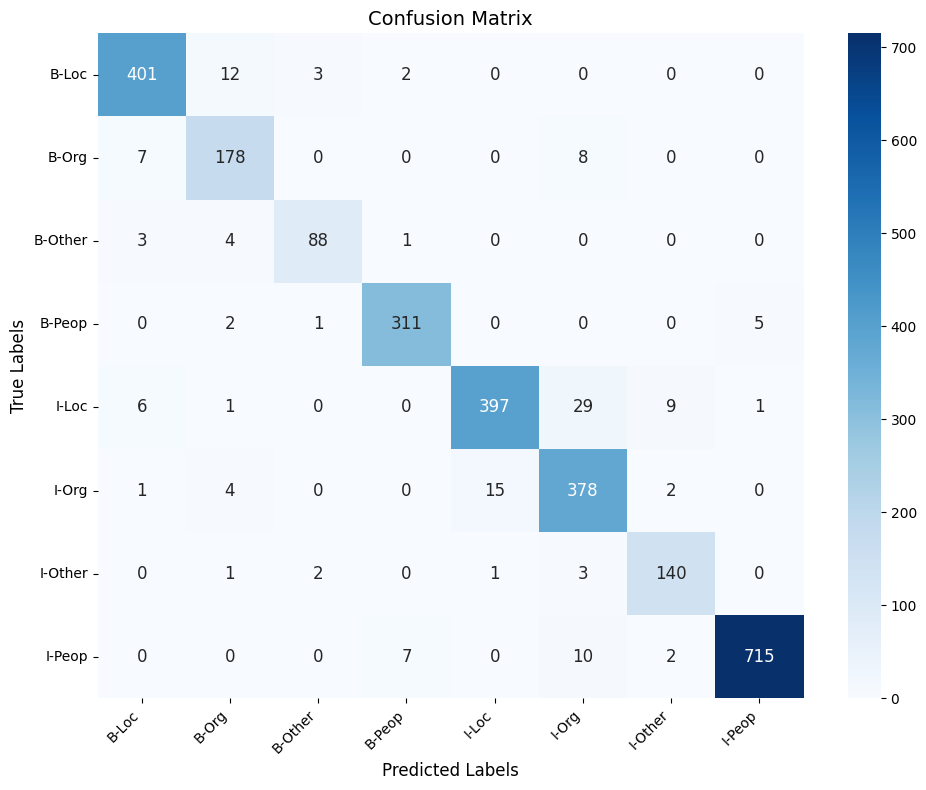

In [41]:
filtered_true = []
filtered_pred = []
for labels_seq, preds_seq in zip(test_labels, test_preds):
    for true_tag_id, pred_tag_id in zip(labels_seq, preds_seq):
        if true_tag_id == -100:
            continue
        true_tag = id2label[true_tag_id]
        pred_tag = id2label[pred_tag_id]
        if true_tag != 'O':
            filtered_true.append(true_tag)
            filtered_pred.append(pred_tag)

labels = sorted(list(set(filtered_true + filtered_pred) - {'O'}))

cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Visualizing

Let's provide vizualization of extracted NERs

In [118]:
df_croped_test['bio_tags'] = df_croped_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_croped_test = df_croped_test[['orig_id', 'texts', 'tokens', 'bio_tags']]
df_croped_test['tokens'] = df_croped_test['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df_croped_test.head()

<ipython-input-118-b7f9f9d79fae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_croped_test['bio_tags'] = df_croped_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
<ipython-input-118-b7f9f9d79fae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_croped_test['tokens'] = df_croped_test['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


orig_id                                              texts  \
0       17  An art exhibit at the Hakawati Theatre in Arab...   
2       34  Reagan sounded positive notes reminiscent of e...   
3       35  There was no mention of the ` ` iron triangle ...   
4       36  Nor did he argue , as he did in a speech at th...   
5       56  Wright , a University of Texas law professor ,...   

                                              tokens  \
0  [An, art, exhibit, at, the, Hakawati, Theatre,...   
2  [Reagan, sounded, positive, notes, reminiscent...   
3  [There, was, no, mention, of, the, `, `, iron,...   
4  [Nor, did, he, argue, ,, as, he, did, in, a, s...   
5  [Wright, ,, a, University, of, Texas, law, pro...   

                                            bio_tags  
0  [O, O, O, O, O, B-Org, I-Org, O, B-Other, O, B...  
2  [B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O...  
3  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
4  [O, O, O, O, O, O, O, O, O, O, O, O, O, B-Org,...  
5  [B-Peop, O, O, B-Org, I-Org, I-Org, O, O, O, O...

Let's make predictions for test data and extract named entities from BIO-tags

In [119]:
predicted_bio_tags_list = []
for index, row in df_croped_test.iterrows():
    tokenized = tokenizer(
        row["tokens"],
        is_split_into_words=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        pred_tags = model(tokenized['input_ids'], tokenized['attention_mask'])

    # labels to bio_tags
    pred_subtoken_tags = [id2label[tag] for tag in pred_tags[0]]

    word_ids = tokenized.word_ids(batch_index=0)

    aligned_preds = []
    for token_idx, token in enumerate(row["tokens"]):
        subtoken_idxs = [i for i, w_id in enumerate(word_ids) if w_id == token_idx]

        if not subtoken_idxs:
            continue
        pred_tag = pred_subtoken_tags[subtoken_idxs[0]] # tag of the first subtoken
        aligned_preds.append(pred_tag)

    predicted_bio_tags_list.append(aligned_preds)

In [120]:
def extract_entities(tokens, tags, valid_types={"Peop", "Org", "Loc"}):
    entities = []
    current_entity = None

    for idx, (token, tag) in enumerate(zip(tokens, tags)):
        if tag.startswith("B-"):
            entity_type = tag[2:]
            if entity_type in valid_types:
                # create new entity
                if current_entity:
                    entities.append(current_entity)
                current_entity = {
                    "text": token,
                    "type": entity_type,
                    "start": idx,
                    "end": idx + 1
                }
            else:
                # ignore 'Other' tag
                if current_entity:
                    entities.append(current_entity)
                current_entity = None
        elif tag.startswith("I-"):
            entity_type = tag[2:]
            if current_entity and current_entity["type"] == entity_type:
                # continuation of entity
                current_entity["text"] += " " + token
                current_entity["end"] += 1
            else:
                # ignore 'Other' tag
                if current_entity:
                    entities.append(current_entity)
                current_entity = None
        else:  # tag == "O"
            if current_entity:
                entities.append(current_entity)
            current_entity = None
    if current_entity:
        entities.append(current_entity)

    return entities

In [121]:
df_croped_test["predicted_bio_tags"] = predicted_bio_tags_list
df_croped_test["predicted_entities"] = df_croped_test.apply(
    lambda row: extract_entities(row["tokens"], row["predicted_bio_tags"]),
    axis=1
)
df_croped_test = df_croped_test[df_croped_test['predicted_entities'].apply(lambda x: len(x) == 2)]
df_croped_test.head()

orig_id                                              texts  \
2        34  Reagan sounded positive notes reminiscent of e...   
11      130                 Hot Springs National Park , Ark. ;   
12      136                          Aguadilla , Puerto Rico ;   
14      150                              ATLANTIC CITY , N.J .   
15      171                                   FRESNO , Calif .   

                                               tokens  \
2   [Reagan, sounded, positive, notes, reminiscent...   
11         [Hot, Springs, National, Park, ,, Ark., ;]   
12                    [Aguadilla, ,, Puerto, Rico, ;]   
14                        [ATLANTIC, CITY, ,, N.J, .]   
15                              [FRESNO, ,, Calif, .]   

                                             bio_tags  \
2   [B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O...   
11          [B-Loc, I-Loc, I-Loc, I-Loc, O, B-Loc, O]   
12                        [B-Loc, O, B-Loc, I-Loc, O]   
14                    [B-Loc, I-Loc, O, B-Loc, I-Loc]   
15                           [B-Loc, O, B-Loc, I-Loc]   

                                   predicted_bio_tags  \
2   [B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O...   
11          [B-Loc, I-Loc, I-Loc, I-Loc, O, B-Loc, O]   
12                        [B-Loc, O, B-Loc, I-Loc, O]   
14                    [B-Loc, I-Loc, O, B-Loc, I-Loc]   
15                           [B-Loc, O, B-Loc, I-Loc]   

                                   predicted_entities  
2   [{'text': 'Reagan', 'type': 'Peop', 'start': 0...  
11  [{'text': 'Hot Springs National Park', 'type':...  
12  [{'text': 'Aguadilla', 'type': 'Loc', 'start':...  
14  [{'text': 'ATLANTIC CITY', 'type': 'Loc', 'sta...  
15  [{'text': 'FRESNO', 'type': 'Loc', 'start': 0,...

In [122]:
RELATIONS = {
    "Kill": ("Peop", "Peop"),
    "Live_In": ("Peop", "Loc"),
    "Work_For": ("Peop", "Org"),
    "Located_In": ("Loc", "Loc"),
    "OrgBased_In": ("Org", "Loc")
}

def build_global_knowledge_graph(df, relations=RELATIONS):
    G = nx.DiGraph()
    node_occurrences = {}
    edge_set = set()

    for idx in range(len(df)):
        entities = df.iloc[idx]["predicted_entities"]

        # track node occurrences
        entity_set = set((ent["text"], ent["type"]) for ent in entities)
        for node in entity_set:
            if node in node_occurrences:
                node_occurrences[node] += 1
            else:
                node_occurrences[node] = 1

        # add local relations according to rules
        entities_by_type = {}
        for ent in entities:
            typ = ent["type"]
            txt = ent["text"]
            if typ not in entities_by_type:
                entities_by_type[typ] = []
            entities_by_type[typ].append(txt)

        for rel_name, (src_type, dst_type) in relations.items():
            src_nodes = entities_by_type.get(src_type, [])
            dst_nodes = entities_by_type.get(dst_type, [])
            for s in src_nodes:
                for d in dst_nodes:
                    if s != d:
                        src_node = (s, src_type)
                        dst_node = (d, dst_type)
                        edge_set.add((src_node, dst_node, rel_name))

    # add nodes with fixed count
    for (text, ntype), count in node_occurrences.items():
        G.add_node((text, ntype), type=ntype, count=count)

    # add edges
    for u, v, rel in edge_set:
        G.add_edge(u, v, relation=rel)

    return G

In [125]:
def visualize_global_knowledge_graph(G):
    color_map = {
        "Peop": "yellow",
        "Org": "red",
        "Loc": "green"
    }

    plt.figure(figsize=(40, 40))

    pos = nx.spring_layout(G, seed=84, k=0.6)

    # node sizes: base_size + (occurrence_count * scaling_factor)
    node_sizes = [
        800 + 300 * G.nodes[node].get("count", 0)  # bigger if count >= 1
        for node in G.nodes()
    ]

    node_colors = [color_map[G.nodes[node]["type"]] for node in G.nodes()]

    edgecolors = ["black" if G.nodes[node].get("count", 0) >= 2 else "none" for node in G.nodes()]
    linewidths = [2 if G.nodes[node].get("count", 0) >= 2 else 0 for node in G.nodes()]


    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors=edgecolors,
        linewidths=linewidths,
        alpha=0.7
    )

    nx.draw_networkx_edges(
        G, pos,
        edgelist=G.edges(),
        arrowstyle='->',
        arrowsize=20,
        edge_color="gray"
    )

    labels = {node: node[0] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)


    edge_labels = {(u, v): d["relation"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Global Knowledge Graph")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

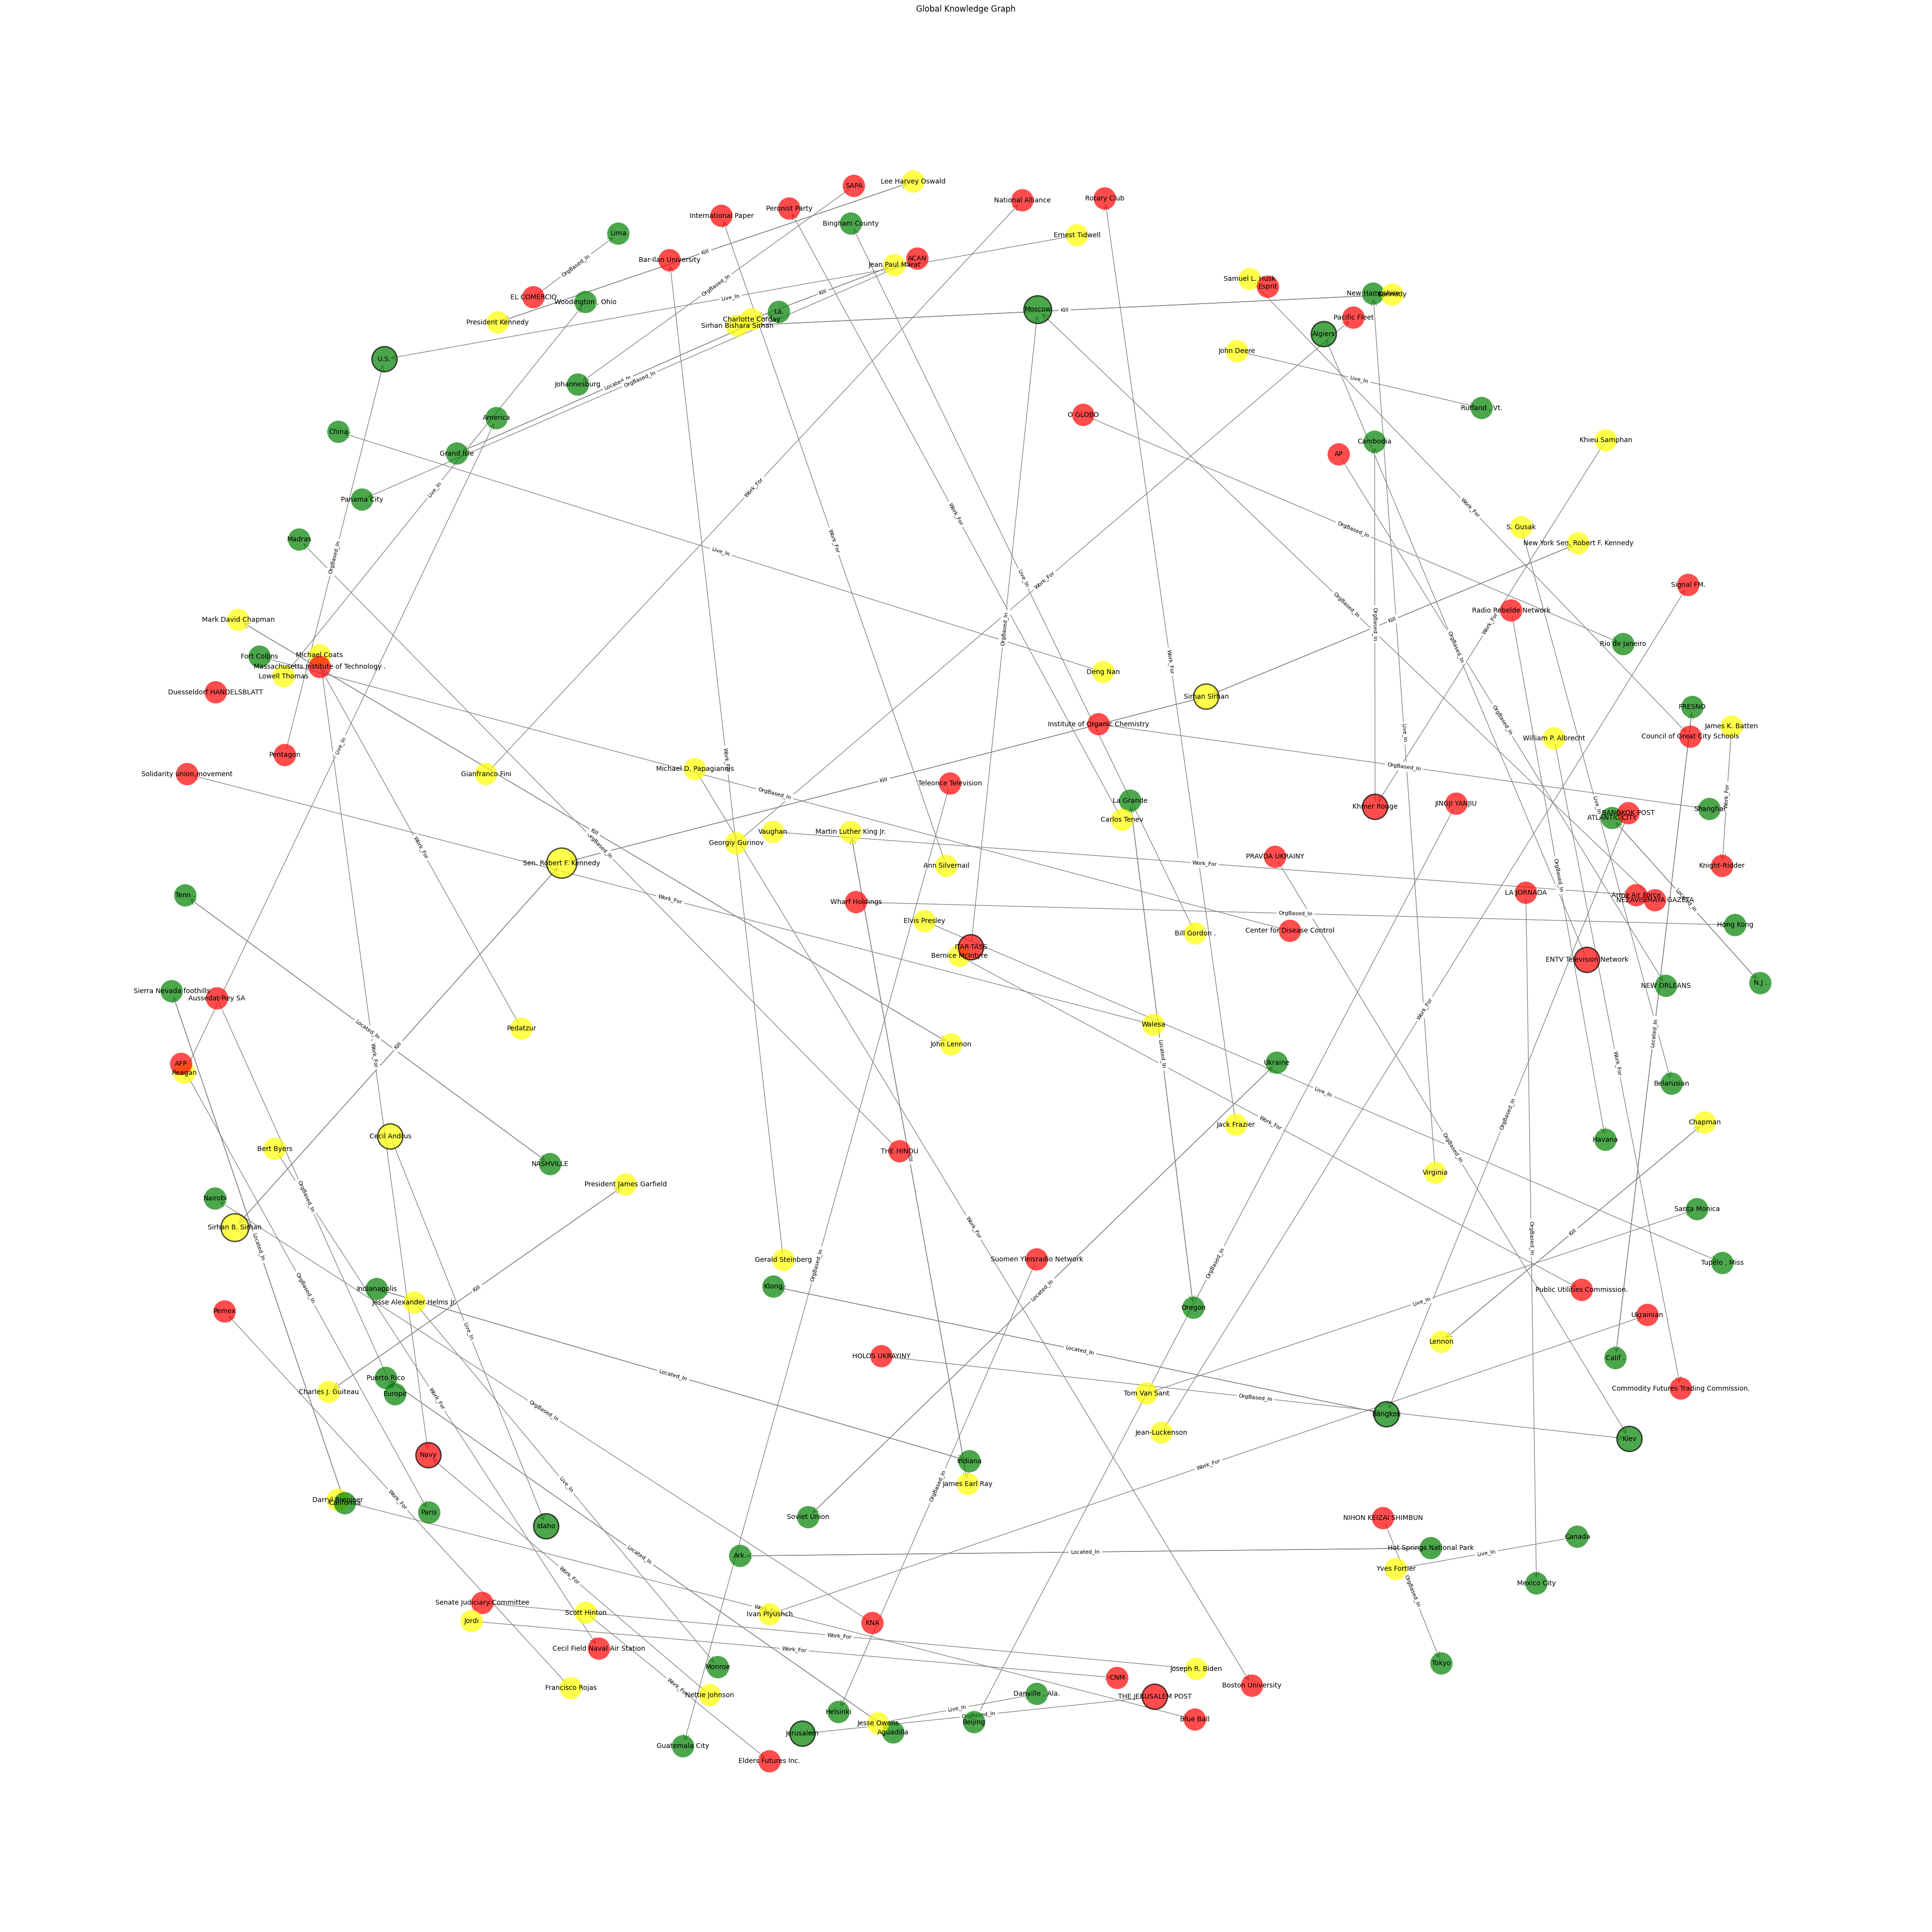

In [124]:
global_graph = build_global_knowledge_graph(df_croped_test)
visualize_global_knowledge_graph(global_graph)

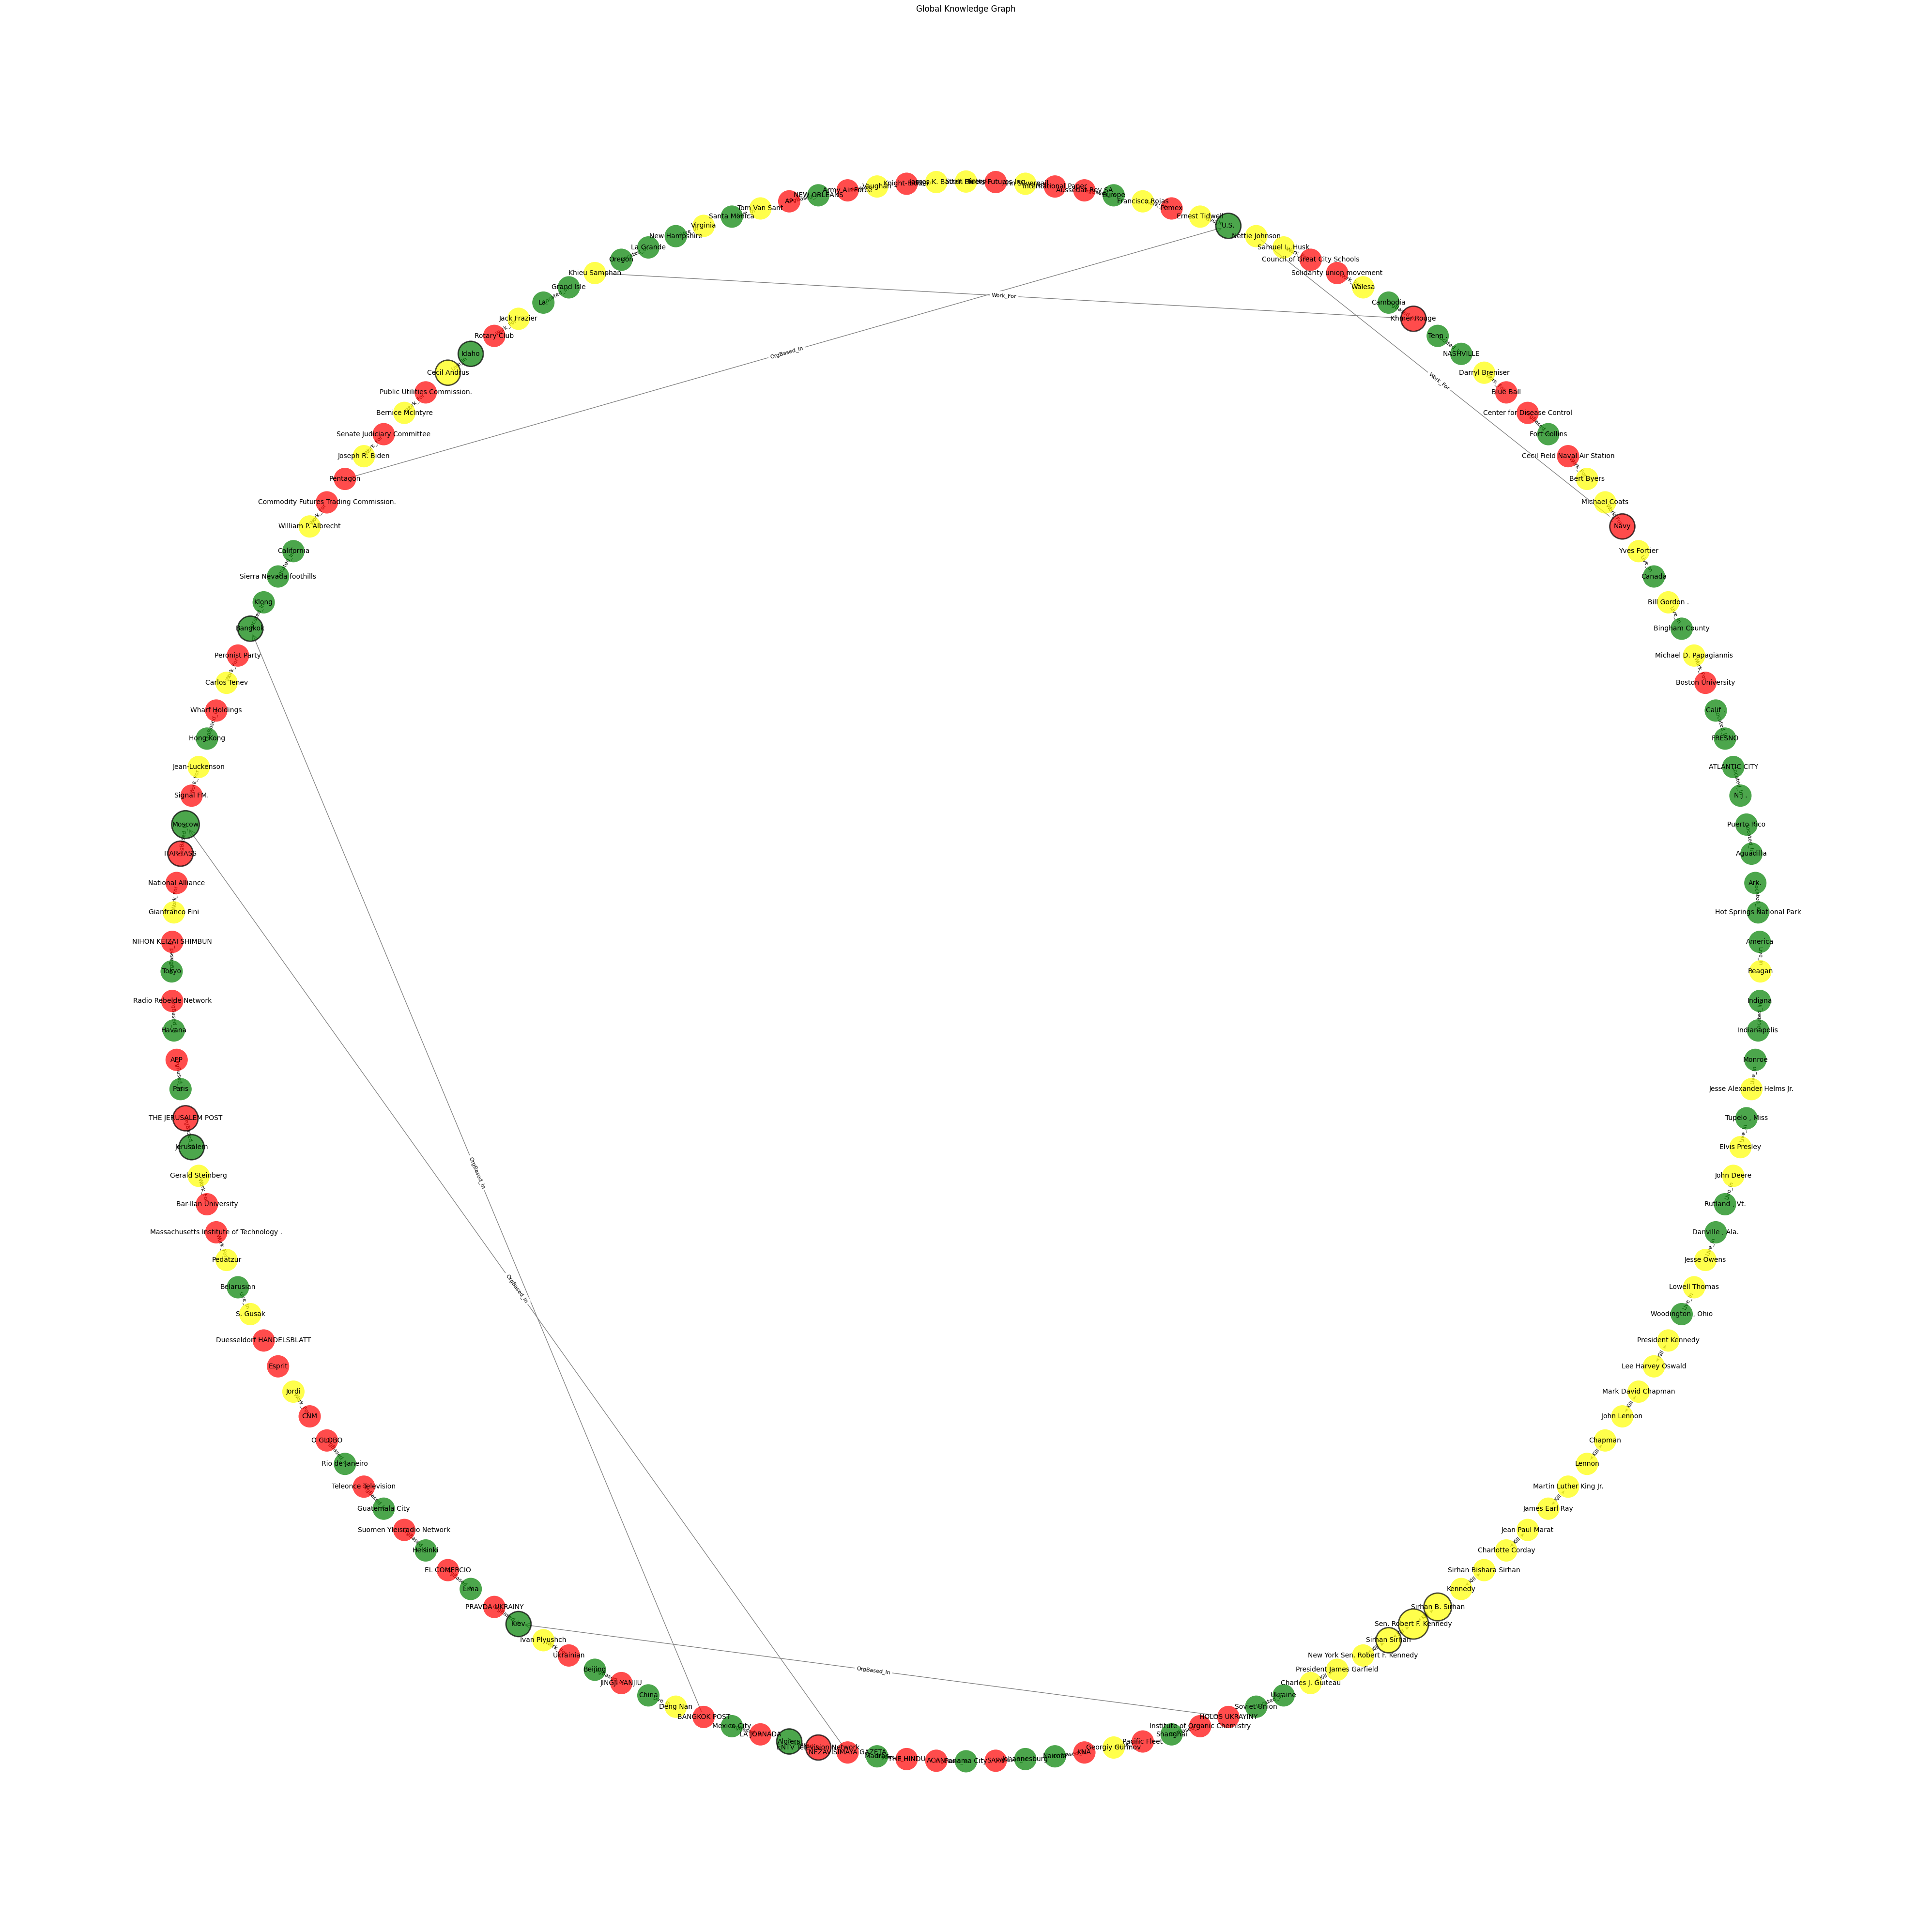

In [126]:
# circular_layout
global_graph = build_global_knowledge_graph(df_croped_test)
visualize_global_knowledge_graph(global_graph)